In [ ]:
!pip install transformers evaluate sentencepiece nltk datasets rouge_score

In [212]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForSeq2Seq
from datasets import load_dataset, Features, Value
import random
from tqdm.auto import tqdm, trange
import os
from sklearn.model_selection import train_test_split
import re
import json
import gc
import evaluate
import sentencepiece

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

In [213]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load config

Load config for T5 model

In [214]:
config_file = '/content/config_T5.json'
with open(config_file, "r") as r:
    config = json.load(r)
config

{'batch_size': 2,
 'epoch_number': 5,
 'learning_rate': 1e-06,
 'num_train_epochs': 10,
 'gradient_accumulation_steps': 2,
 'max_target_tokens_count': 1024,
 'max_source_tokens_count': 1024,
 'logging_steps': 25,
 'report_steps': 20,
 'save_steps': 100,
 'eval_steps': 20,
 'warmup_steps': 5,
 'model_type': 'seq2seq_lm',
 'model_name': 't5-base',
 'path_to_dataset': '/content/dataset_processed.json',
 'output_dir': 'model_best',
 'test_size': 0.2,
 'seed': 1}

# Load dataset

Load processed dataset in .json format

In [215]:
# load dataset
path_to_dataset = config['path_to_dataset']

In [217]:
lyrics_data = load_dataset('json', data_files=path_to_dataset)

In [218]:
lyrics_data = lyrics_data['train']

In [219]:
lyrics_data[0]

{'text': "[Verse 1]\nOnce the last drop of rain has dried off the pavement\nShouldn't I find a stain? But I never do\nThe way the tires turn stones on old county roads\nThey leave 'em muddy underneath, reminds me of you\nYou find graffiti on the walls of old bathroom stalls, you know\nYou can scratch it right off, it's how it used to be\nBut like the dollar in your pocket, it's been spent and traded in\nYou can't change where it's been, reminds me of me\n\n[Chorus: Taylor Swift & Maren Morris]\nI lived and I learned\nHad you, got burned\nHeld out and held on\nGod knows, too long, and wasted time\nLost tears, swore that I'd get out of here\nBut no amount of freedom gets you clean\nI've still got you all over me",
 'summary': '[Verse 2: Taylor Swift, Taylor Swift & Maren Morris]\nThe best and worst day of June\nWas the one that I met you\nWith your hands in your pockets\nAnd your "Don\'t you wish you had me?" grin\nWell I did, so I smiled, and I melted like a child\nNow, every breath of 

Split data to train and validation parts

In [220]:
lyrics_data = lyrics_data.train_test_split(test_size=config['test_size'], shuffle=True, seed=config['seed'])

In [221]:
lyrics_data['train']

Dataset({
    features: ['text', 'summary'],
    num_rows: 154
})

In [222]:
lyrics_data['test']

Dataset({
    features: ['text', 'summary'],
    num_rows: 39
})

# Load model

Load model, tokenizer and optimizer. We use T5 base and Adam   

In [ ]:
# load model
raw_model = None
model = None

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

raw_model = config['model_name']
model = T5ForConditionalGeneration.from_pretrained(raw_model).to('cuda')
tokenizer = T5Tokenizer.from_pretrained(raw_model)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])


We need to train model for the correct newline placement. But t5 tokenizer simply remove newline symbols from data.

So we need to replace them to some simple but rare tokens, for example underscore

In [224]:
# tokenization func
def preprocess_function(examples):
    # Replace newline characters with a special token
    examples["text"] = [text.replace('\n', ' _ ') for text in examples["text"]]
    examples["summary"] = [summary.replace('\n', ' _ ') for summary in examples["summary"]]

    model_inputs = tokenizer(
        examples["text"],
        max_length=config['max_source_tokens_count'],
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=config['max_target_tokens_count'], truncation=True
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def decode_output(output):
    # Replace the special character with newline
    text = re.sub(r'\s*_\s*', '\n', output)
    return text

In [225]:
lyrics_data_tok = lyrics_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/154 [00:00<?, ? examples/s]

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

In [226]:
lyrics_data_tok = lyrics_data_tok.remove_columns(
    lyrics_data["train"].column_names
)

In [227]:
#news_data_tok.reset_format()
lyrics_data_tok.set_format(type='torch')

We can consider this problem as Seq2Seq task. So we will use the corresponding data collator

In [228]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model, padding=True, max_length=config['max_source_tokens_count'])

In [229]:
dataloader_train = DataLoader(lyrics_data_tok['train'], batch_size=config['batch_size'], shuffle=True,\
                             collate_fn=data_collator)

dataloader_val = DataLoader(lyrics_data_tok['test'], batch_size=config['batch_size'], shuffle=False,\
                             collate_fn=data_collator)

OneCycleLR scheduler seems to be effective in a wide range of tasks

In [230]:
# scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=4*config['learning_rate'],\
                                                steps_per_epoch=len(dataloader_train), epochs=config['epoch_number'])

In [231]:
len(dataloader_train)

77

It is tricky to choose metrics for this problem. We want our model to catch the style of the song not just repeat 
the target text. 

However it is not clear how can one define the style. But we may just use standart metrics as our starting point

In [234]:
#metrics
rouge_score = evaluate.load("rouge")
bleu_score = evaluate.load("bleu")

# Train and validation

Training loop. We save the model which shows the best BLEU score on validation

In [235]:
# train and validation

losses = []
val_losses = []
scores_bl_list = []
scores_rouge_list = []
scores_bleu_epoch = -100
report_steps = config["report_steps"]
for epoch in range(config['epoch_number']):
    model.train()
    print('EPOCH', epoch)

    i = 0
    for batch in tqdm(dataloader_train):

        loss = model(
            input_ids=batch.input_ids.to(model.device),
            labels=batch.labels.to(model.device),
            return_dict=True
        ).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())

        i+=1
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))
            print(f'\nLast lr: {scheduler.get_last_lr()}')

    # validation
    model.eval()
    predictions_list = []
    targets_list = []
    text_list = []
    with torch.no_grad():
        for batch in tqdm(dataloader_val):
            output_ids = model.generate(input_ids=batch.input_ids.to(model.device), no_repeat_ngram_size=4,
                                    do_sample=True, early_stopping=True, max_length=200, temperature=1.0)

            texts = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in batch.input_ids]
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in output_ids]

            batch.labels[batch.labels == -100] = tokenizer.pad_token_id
            targets = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in batch.labels]

            #we need to seperate sentences with \n for rouge correct evaluation
            preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
            targets = ["\n".join(nltk.sent_tokenize(target)) for target in targets]

            predictions_list.extend(preds)
            targets_list.extend(targets)
            text_list.extend(texts)

        scores_rouge = rouge_score.compute(predictions=predictions_list, references=targets_list, tokenizer=word_tokenize)
        scores_rouge_list.append(scores_rouge)
        print(f'\nScores rouge: {scores_rouge}')
        scores_bleu = bleu_score.compute(predictions=predictions_list, references=targets_list, tokenizer=word_tokenize)
        scores_bl_list.append(scores_bleu)
        print(f'\nScores bleu: {scores_bleu}')

        if scores_bleu['bleu'] > scores_bleu_epoch:
            new_model_name = config['output_dir']
            model.save_pretrained(new_model_name)
            tokenizer.save_pretrained(new_model_name)
            print(f'EPOCH {epoch}, model saved to {new_model_name}')
            scores_bleu_epoch = scores_bleu['bleu']

EPOCH 0


  0%|          | 0/77 [00:00<?, ?it/s]

step 20 loss 13.691076278686523

Last lr: [4.4189955560725246e-07]
step 40 loss 13.627691650390625

Last lr: [1.2048197230002943e-06]
step 60 loss 12.266573476791383

Last lr: [2.224732527020888e-06]


  0%|          | 0/20 [00:00<?, ?it/s]


Scores rouge: {'rouge1': 0.22469225259145667, 'rouge2': 0.1034394850332666, 'rougeL': 0.1613554654336125, 'rougeLsum': 0.1808030163703559}

Scores bleu: {'bleu': 0.004419109024610216, 'precisions': [0.6172350791717418, 0.27704160246533127, 0.13537117903930132, 0.08462267129775813], 'brevity_penalty': 0.021005478687918643, 'length_ratio': 0.20563556668753913, 'translation_length': 3284, 'reference_length': 15970}
EPOCH 0, model saved to model_best
EPOCH 1


  0%|          | 0/77 [00:00<?, ?it/s]

step 20 loss 8.54623098373413

Last lr: [3.7828918458131976e-06]
step 40 loss 6.892872381210327

Last lr: [3.99915076135441e-06]
step 60 loss 5.874797034263611

Last lr: [3.93160027468214e-06]


  0%|          | 0/20 [00:00<?, ?it/s]


Scores rouge: {'rouge1': 0.2326054780373918, 'rouge2': 0.09561387594279089, 'rougeL': 0.1563202508705063, 'rougeLsum': 0.17657691024825983}

Scores bleu: {'bleu': 0.00483522595075641, 'precisions': [0.6213364595545134, 0.25437296175511415, 0.1205758848230354, 0.07101669195751138], 'brevity_penalty': 0.025209376429002516, 'length_ratio': 0.21365059486537258, 'translation_length': 3412, 'reference_length': 15970}
EPOCH 1, model saved to model_best
EPOCH 2


  0%|          | 0/77 [00:00<?, ?it/s]

step 20 loss 4.448419427871704

Last lr: [3.5379028990745216e-06]
step 40 loss 4.22457846403122

Last lr: [3.2008902566761114e-06]
step 60 loss 3.8213029861450196

Last lr: [2.798898386077968e-06]


  0%|          | 0/20 [00:00<?, ?it/s]


Scores rouge: {'rouge1': 0.23575238868905168, 'rouge2': 0.10727286381927645, 'rougeL': 0.16591659724083418, 'rougeLsum': 0.18280524442531498}

Scores bleu: {'bleu': 0.005282919661472261, 'precisions': [0.6252204585537919, 0.27951234017246507, 0.13778580024067388, 0.08462709284627093], 'brevity_penalty': 0.024864915825657186, 'length_ratio': 0.21302442078897935, 'translation_length': 3402, 'reference_length': 15970}
EPOCH 2, model saved to model_best
EPOCH 3


  0%|          | 0/77 [00:00<?, ?it/s]

step 20 loss 3.6609155774116515

Last lr: [1.9592110884054893e-06]
step 40 loss 3.528280532360077

Last lr: [1.4983409191869048e-06]
step 60 loss 3.4854594230651856

Last lr: [1.0646157423630583e-06]


  0%|          | 0/20 [00:00<?, ?it/s]


Scores rouge: {'rouge1': 0.23218865968612273, 'rouge2': 0.1016135234389686, 'rougeL': 0.15987654296122716, 'rougeLsum': 0.17710664944342147}

Scores bleu: {'bleu': 0.0052751820121178915, 'precisions': [0.6143523920653442, 0.26674535261138976, 0.12955223880597014, 0.0827544548474781], 'brevity_penalty': 0.0257661641323532, 'length_ratio': 0.21465247338760177, 'translation_length': 3428, 'reference_length': 15970}
EPOCH 4


  0%|          | 0/77 [00:00<?, ?it/s]

step 20 loss 3.4042195081710815

Last lr: [4.11240184272458e-07]
step 40 loss 3.3979497075080873

Last lr: [1.735571256934769e-07]
step 60 loss 3.4489336967468263

Last lr: [3.470254717353245e-08]


  0%|          | 0/20 [00:00<?, ?it/s]


Scores rouge: {'rouge1': 0.23767407302946755, 'rouge2': 0.10473544293181211, 'rougeL': 0.16431811371649313, 'rougeLsum': 0.1837829550188019}

Scores bleu: {'bleu': 0.005564530222507383, 'precisions': [0.6245288489417222, 0.2709677419354839, 0.13230495401957876, 0.08673469387755102], 'brevity_penalty': 0.026507498302641926, 'length_ratio': 0.21596743894802756, 'translation_length': 3449, 'reference_length': 15970}
EPOCH 4, model saved to model_best


We can save losses and metrics to files. Better option is to use Wandb of course. However for some reason we have used oldschool technique here

In [236]:
with open('losses.txt', 'w') as f:
    f.write(str(losses))

with open('rouge.txt', 'w') as f:
    f.write(str(scores_rouge_list))

with open('blue.txt', 'w') as f:
    f.write(str(scores_bl_list))

In [237]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Just the plot of the train loss

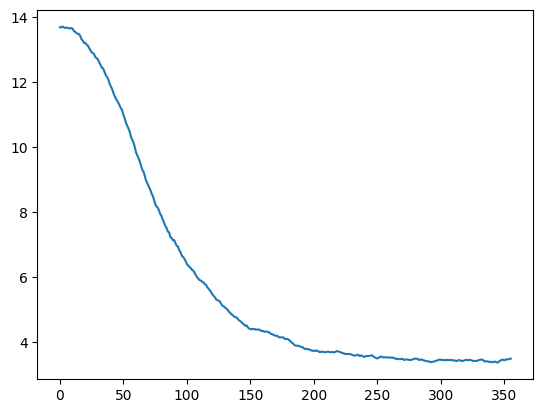

In [238]:
plt.plot(moving_average(losses, n=30))

# Load best model

Here we just load the best model and look at its performance

In [243]:
# load model
raw_model = None
model = None

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

raw_model = "/content/model_best"
model = T5ForConditionalGeneration.from_pretrained(raw_model).cuda()
tokenizer = T5Tokenizer.from_pretrained(raw_model)

For generation we use nucleus sampling with rather high temperature and top_k parameters. This should be appropriate for lyrics generation model  

However we try to fight repetitions as model tends to repeat the initial text a lot 

In [324]:
# generation
model.eval()
predictions_list = []
targets_list = []
text_list = []
with torch.no_grad():
    for batch in tqdm(dataloader_val):

        output_ids = model.generate(input_ids=batch.input_ids.to(model.device), no_repeat_ngram_size=3,
                                    do_sample=True, early_stopping=True, max_length=200, temperature=1.2,
                                    repetition_penalty=1.6, top_k=40, top_p=0.95)

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in output_ids]
        texts = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in batch.input_ids]

        batch.labels[batch.labels == -100] = tokenizer.pad_token_id
        targets = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in batch.labels]

        predictions_list.extend(preds)
        targets_list.extend(targets)
        text_list.extend(texts)

  0%|          | 0/20 [00:00<?, ?it/s]

We should replace our underscore symbol _ back to newline symbol

In [326]:
targets_proc = [decode_output(target) for target in targets_list]
predictions_list_proc = [decode_output(pred) for pred in predictions_list]
texts_proc = [decode_output(text) for text in text_list]

In [317]:
len(targets_list)

39

In [336]:
print(texts_proc[25])

[Verse 1]
The drought was the very worst (Oh-oh, oh-oh)
When the flowers that we'd grown together died of thirst
It was months and months of back and forth (Oh-oh, oh-oh)
You're still all over me
Like a wine-stained dress I can't wear anymore

[Pre-Chorus]
Hung my head as I lost the war
And the sky turned black like a perfect storm


In [335]:
print(predictions_list_proc[25])

[Summary]
When the flowers that we'd grown together began to dry out
And it was years and months of back and forth (Oh-oh, Oh-hhh)
a drought that had turned into a total destruction in heaven... The air turned black like a perfect storm
At night I looked down at this ice-cold blue
But as I watched from faraway. And what he saw was pure bliss: A sea with no sign of God; And


# Save results

In [ ]:
df = pd.DataFrame({'pred': predictions_list_proc, 'target': targets_proc})

In [333]:
# Create a list of dictionaries
data = []
for text, target, prediction in zip(texts_proc, targets_proc, predictions_list_proc):
    data.append({
        'text': text,
        'target': target,
        'prediction': prediction
    })

# Save to JSON
with open('output_dataset_2.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)